<a href="https://colab.research.google.com/github/depiana/gift-project/blob/main/ML_AI%20Learning%20Insight_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Install Library**

In [1]:
!pip install numpy==1.26.4 scikit-learn==1.5.2 joblib==1.3.2 pandas==2.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 74.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 110.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 22.5 MB/s eta 0:00:00
  Created wheel for pandas: filename=pandas-2.0.3-cp312-cp312-linux_x86_64.whl size=42828406 sha256=da4127e844c04693fdb5c146224dbf1f5507847257138ff7b07d556d6e735f3b
  Stored in directory: /root/.cache/pip/wheels/08/95/b7/15a2a9958c1fde0807c23b05bfed1a32ff9c7225c55d270d27
Successfully built pandas
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninsta

**2. Import Library**

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

**3. Fungsi Pembersihan Data (Cleaning)**

In [2]:
def clean_numeric_id(series):
    """Membersihkan ID yang ada koma/kutip."""
    if pd.api.types.is_numeric_dtype(series):
        return series.astype('Int64')
    return pd.to_numeric(series.astype(str).str.replace(',', '').str.replace('"', ''), errors='coerce').astype('Int64')

def clean_datetime(series):
    """Mengubah text jadi format tanggal."""
    return pd.to_datetime(series, errors='coerce')

def clean_currency_or_score(series):
    """Membersihkan nilai uang/skor yang ada koma."""
    return pd.to_numeric(series.astype(str).str.replace(',', ''), errors='coerce').fillna(0)

**4. Load Data + Cleaning Data Awal**

In [3]:
# 1. Load USERS
try:
    df_users = pd.read_csv("users - Query result.csv")
    df_users['id'] = clean_numeric_id(df_users['id'])
    print("Users loaded.")
except FileNotFoundError: print("File users - Query result.csv tidak ditemukan.")

# 2. Load TRACKINGS
try:
    df_trackings = pd.read_csv("developer_journey_trackings - Query result.csv")
    df_trackings['developer_id'] = clean_numeric_id(df_trackings['developer_id'])
    df_trackings['first_opened_at'] = clean_datetime(df_trackings['first_opened_at'])
    df_trackings['tutorial_id'] = clean_numeric_id(df_trackings['tutorial_id'])
    print("Trackings loaded.")
except FileNotFoundError: print("File developer_journey_trackings - Query result.csv tidak ditemukan.")

# 3. Load SUBMISSIONS
try:
    df_submissions = pd.read_csv("developer_journey_submissions - Query result.csv")
    df_submissions['submitter_id'] = clean_numeric_id(df_submissions['submitter_id'])
    df_submissions['rating'] = pd.to_numeric(df_submissions['rating'], errors='coerce')
    print("Submissions loaded.")
except FileNotFoundError: print("File developer_journey_submissions - Query result.csv tidak ditemukan.")

# 4. Load COMPLETIONS
try:
    df_completions = pd.read_csv("developer_journey_completions - Query result.csv")
    df_completions['user_id'] = clean_numeric_id(df_completions['user_id'])
    df_completions['study_duration'] = clean_currency_or_score(df_completions['study_duration'])
    print("Completions loaded.")
except FileNotFoundError: print("File developer_journey_completions - Query result.csv tidak ditemukan.")

# 5. Load EXAM REGISTRATIONS
try:
    df_exam_reg = pd.read_csv("exam_registrations - Query result.csv")
    print("Exam Registrations loaded (Format Baru).")
except FileNotFoundError:
    try:
        df_exam_reg = pd.read_csv("exam_registrations.xlsx - Query result.csv")
        print("Exam Registrations loaded (Format Lama).")
    except FileNotFoundError:
        print("File exam_registrations tidak ditemukan. (Pakai dummy)")
        df_exam_reg = pd.DataFrame(columns=['id', 'examinees_id', 'created_at', 'exam_finished_at'])

# Rename & Clean Exam Reg
if 'id' in df_exam_reg.columns:
    df_exam_reg = df_exam_reg.rename(columns={'id': 'registration_id', 'examinees_id': 'user_id'})
df_exam_reg['registration_id'] = clean_numeric_id(df_exam_reg['registration_id'])
df_exam_reg['user_id'] = clean_numeric_id(df_exam_reg['user_id'])
df_exam_reg['started_at'] = clean_datetime(df_exam_reg['created_at'])
df_exam_reg['finished_at'] = clean_datetime(df_exam_reg['exam_finished_at'])
df_exam_reg['exam_duration_mins'] = (df_exam_reg['finished_at'] - df_exam_reg['started_at']).dt.total_seconds() / 60
df_exam_reg = df_exam_reg[df_exam_reg['exam_duration_mins'] > 0]

# 6. Load EXAM RESULTS
try:
    df_exam_res = pd.read_csv("exam_results - Query result.csv")
    print("Exam Results loaded (Format Baru).")
except FileNotFoundError:
    try:
        df_exam_res = pd.read_csv("exam_results.xlsx - Query result.csv")
        print("Exam Results loaded (Format Lama).")
    except FileNotFoundError:
        print("File exam_results tidak ditemukan. (Pakai dummy)")
        df_exam_res = pd.DataFrame(columns=['exam_registration_id', 'point'])

# Clean Exam Results & Merge
df_exam_res['exam_registration_id'] = clean_numeric_id(df_exam_res['exam_registration_id'])
col_score = 'point' if 'point' in df_exam_res.columns else 'score'
df_exam_res['score'] = clean_currency_or_score(df_exam_res[col_score])

# Merge Result ke Registration untuk dapat User ID
df_exam_res = df_exam_res.merge(
    df_exam_reg[['registration_id', 'user_id']],
    left_on='exam_registration_id',
    right_on='registration_id',
    how='left'
)
df_exam_res = df_exam_res.dropna(subset=['user_id'])

Users loaded.
Trackings loaded.
Submissions loaded.
Completions loaded.
Exam Registrations loaded (Format Baru).
Exam Results loaded (Format Baru).


**5. Feature Engineering**

In [4]:
# A. Konsistensi
feat_consistency = df_trackings.groupby('developer_id').agg(
    total_active_days=pd.NamedAgg(column='first_opened_at', aggfunc=lambda x: x.dt.date.nunique()),
    total_modules_opened=pd.NamedAgg(column='tutorial_id', aggfunc='count')
).reset_index()

# B. Kecepatan
feat_speed_learn = df_completions.groupby('user_id')['study_duration'].mean().reset_index(name='avg_study_duration')
feat_speed_exam = df_exam_reg.groupby('user_id')['exam_duration_mins'].mean().reset_index(name='avg_exam_duration')

# C. Kualitas
feat_quality_sub = df_submissions.groupby('submitter_id')['rating'].mean().reset_index(name='avg_submission_rating')
feat_quality_exam = df_exam_res.groupby('user_id')['score'].mean().reset_index(name='avg_exam_score')

# D. Gabung Semua
df_final = df_users[['id']].rename(columns={'id': 'user_id'})
df_final = df_final.merge(feat_consistency, left_on='user_id', right_on='developer_id', how='left')
df_final = df_final.merge(feat_speed_learn, on='user_id', how='left')
df_final = df_final.merge(feat_speed_exam, on='user_id', how='left')
df_final = df_final.merge(feat_quality_sub, left_on='user_id', right_on='submitter_id', how='left')
df_final = df_final.merge(feat_quality_exam, on='user_id', how='left')

df_final = df_final.drop(columns=['developer_id', 'submitter_id'], errors='ignore')
df_final = df_final.fillna(0)
df_final = df_final[df_final['total_active_days'] > 0].copy()

print(f"Jumlah Siswa Asli: {len(df_final)}")

Jumlah Siswa Asli: 31


**6. Data Augmentation**

In [5]:
TARGET_TOTAL = 500  # Target jumlah siswa

# Fitur yang akan digenerate
features = ['total_active_days', 'avg_study_duration', 'avg_exam_duration',
            'avg_submission_rating', 'avg_exam_score']

if len(df_final) < TARGET_TOTAL:
    print(f"Mendeteksi jumlah data sedikit ({len(df_final)}). Menambah hingga {TARGET_TOTAL}...")

    # 1. Ambil Statistik Data Asli (Mean & Std Dev)
    stats = df_final[features].agg(['mean', 'std']).to_dict()

    # 2. Generate Data Baru
    num_new = TARGET_TOTAL - len(df_final)
    new_data = {}
    np.random.seed(42) # Agar hasil konsisten

    for col in features:
        mean_val = stats[col]['mean']
        std_val = stats[col]['std']

        # Generate angka random normal distribution
        # std_val * 1.2 agar variasi data dummy sedikit lebih luas dari data asli
        values = np.random.normal(loc=mean_val, scale=std_val * 1.2, size=num_new)

        # Batasan Logis (Tidak boleh minus, rating max 5, score max 100)
        values = np.maximum(values, 0) # Minimal 0
        if 'rating' in col: values = np.minimum(values, 5)
        if 'score' in col: values = np.minimum(values, 100)

        new_data[col] = values

    # 3. Buat DataFrame Dummy
    df_dummy = pd.DataFrame(new_data)

    # Buat User ID Palsu (Lanjutan dari ID asli)
    last_id = df_final['user_id'].max()
    df_dummy['user_id'] = range(last_id + 1, last_id + 1 + num_new)

    # Gabungkan Data Asli + Dummy
    df_augmented = pd.concat([df_final[['user_id'] + features], df_dummy], ignore_index=True)

    print(f"Berhasil menambah {num_new} siswa dummy.")
    print(f"Total Data Sekarang: {len(df_augmented)} Siswa")
else:
    print("Data sudah cukup banyak. Tidak perlu augmentasi.")
    df_augmented = df_final.copy()

Mendeteksi jumlah data sedikit (31). Menambah hingga 500...
Berhasil menambah 469 siswa dummy.
Total Data Sekarang: 500 Siswa


**7. Clustering Gaya Belajar (KMeans)**

In [6]:
X = df_augmented[features]

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_augmented['cluster'] = kmeans.fit_predict(X_scaled)

# Labeling Otomatis
cluster_means = df_augmented.groupby('cluster')[features].mean()
fast_c = cluster_means['avg_study_duration'].idxmin() # Paling cepat belajar
remaining = cluster_means.drop(index=fast_c)
reflective_c = remaining[['avg_submission_rating', 'avg_exam_score']].mean(axis=1).idxmax() # Nilai paling tinggi
consistent_c = list({0, 1, 2} - {fast_c, reflective_c})[0] # Sisanya

label_map = {fast_c: 'Fast Learner', reflective_c: 'Reflective', consistent_c: 'Consistent'}
df_augmented['gaya_belajar'] = df_augmented['cluster'].map(label_map)

print(f"Labeling Mapping: {label_map}")
print(df_augmented['gaya_belajar'].value_counts())

Labeling Mapping: {2: 'Fast Learner', 1: 'Reflective', 0: 'Consistent'}
gaya_belajar
Fast Learner    209
Reflective      154
Consistent      137
Name: count, dtype: int64


**8. Random Forest Classifier**

In [7]:
# Random Forest
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, df_augmented['gaya_belajar'], test_size=0.2, random_state=42, stratify=df_augmented['gaya_belajar'])

clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

**9. Evaluasi Model**

In [8]:
# Evaluasi
acc_train = accuracy_score(y_train, clf.predict(X_train))
acc_test = accuracy_score(y_test, clf.predict(X_test))

print(f"Akurasi Training: {acc_train:.2%}")
print(f"Akurasi Testing : {acc_test:.2%}")

if acc_test < 0.70:
    print("STATUS: UNDERFITTING.")
elif acc_train > 0.95 and (acc_train - acc_test) > 0.10:
    print("STATUS: OVERFITTING")
else:
    print("STATUS: GOOD FIT.")

Akurasi Training: 100.00%
Akurasi Testing : 90.00%
STATUS: GOOD FIT.


**10. Confusion Matrix**

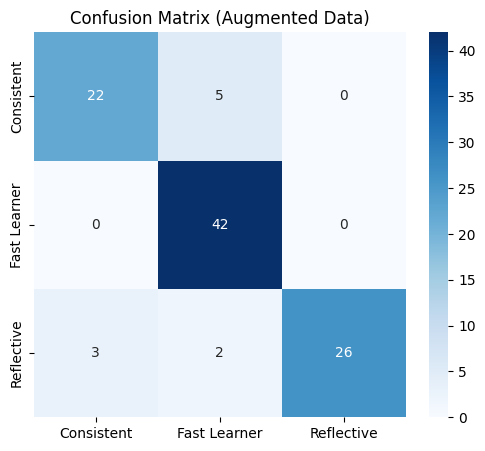

In [9]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, clf.predict(X_test)), annot=True, fmt='d', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Confusion Matrix (Augmented Data)')
plt.show()

**11. Save Model & Scaler**

In [10]:
joblib.dump(clf, 'model_gaya_belajar_rf_augmented.pkl')
joblib.dump(scaler, 'scaler_gaya_belajar_augmented.pkl')

['scaler_gaya_belajar_augmented.pkl']

**12. Export Dataset Final**

In [11]:
try:
    # Pastikan variabel df_augmented ada (hasil dari proses sebelumnya)
    if 'df_augmented' in locals() and not df_augmented.empty:
        file_name_csv = "dataset_gaya_belajar_500_siswa.csv"

        # Simpan ke CSV (index=False biar gak ada kolom nomor baris tambahan)
        df_augmented.to_csv(file_name_csv, index=False)

        print(f"Berhasil! File tersimpan dengan nama: {file_name_csv}")

        # Opsional: Tampilkan preview datanya
        print("\nPreview 5 baris pertama data yang disimpan:")
        print(df_augmented[['user_id', 'gaya_belajar', 'total_active_days', 'avg_exam_score']].head())

    else:
        print("Dataframe 'df_augmented' tidak ditemukan. Pastikan Anda sudah menjalankan Bagian 4 (Data Augmentation).")

except Exception as e:
    print(f"Terjadi kesalahan saat menyimpan CSV: {e}")

Berhasil! File tersimpan dengan nama: dataset_gaya_belajar_500_siswa.csv

Preview 5 baris pertama data yang disimpan:
   user_id  gaya_belajar  total_active_days  avg_exam_score
0    96989  Fast Learner              100.0       70.120275
1   938276  Fast Learner               72.0       83.760479
2  5021477  Fast Learner                4.0       84.300000
3  5044844    Reflective               31.0       91.403846
4  5051374  Fast Learner               16.0       68.645161


**13. Membuat API Flask**

In [12]:
# app.py
from flask import Flask, request, jsonify
import joblib
import pandas as pd

app = Flask(__name__)

# --- 1. LOAD MODEL & SCALER ---
# Load model yang sudah kamu training
print("Loading model AI...")
model = joblib.load('model_gaya_belajar_rf_augmented.pkl')
scaler = joblib.load('scaler_gaya_belajar_augmented.pkl')
print("Model siap!")

# --- 2. BUAT PINTU MASUK (ENDPOINT) ---
@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Terima data JSON yang dikirim oleh Express.js
        data = request.json

        # Susun data sesuai urutan fitur waktu training (JANGAN TUKAR URUTANNYA)
        features = ['total_active_days', 'avg_study_duration', 'avg_exam_duration',
                    'avg_submission_rating', 'avg_exam_score']

        # Ubah ke format DataFrame
        input_data = pd.DataFrame([data], columns=features)

        # Lakukan Scaling (Wajib, karena model dilatih pakai data scaled)
        input_scaled = scaler.transform(input_data)

        # Prediksi Gaya Belajar
        prediction = model.predict(input_scaled)[0]

        # Kirim jawaban balik ke Express.js
        return jsonify({
            'status': 'success',
            'gaya_belajar': prediction # Contoh output: "Fast Learner"
        })

    except Exception as e:
        return jsonify({'status': 'error', 'message': str(e)})

if __name__ == '__main__':
    # Jalankan server di Port 5000
    app.run(host='0.0.0.0', port=5000)

Loading model AI...
Model siap!
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit


**14. Testing API**

In [13]:
# Pastikan 'app' dan 'scaler', 'model' sudah di-load di cell sebelumnya
# Kita gunakan 'test_client' bawaan Flask untuk simulasi tanpa perlu run server beneran

print("--- MENGUJI API SECARA LOKAL ---")

with app.test_client() as client:
    # 1. Siapkan Data Dummy (Ceritanya ini data dari Backend)
    data_dummy = {
        "total_active_days": 70,
        "avg_study_duration": 8000.0,
        "avg_exam_duration": 80.0,
        "avg_submission_rating": 5.0,
        "avg_exam_score": 90.0
    }

    # 2. Kirim ke Endpoint '/predict' (Simulasi POST Request)
    response = client.post('/predict', json=data_dummy)

    # 3. Lihat Hasilnya
    if response.status_code == 200:
        print(" SUKSES! API Membalas:")
        print(response.get_json())
    else:
        print(" ERROR:")
        print(response.get_data(as_text=True))

--- MENGUJI API SECARA LOKAL ---
 SUKSES! API Membalas:
{'gaya_belajar': 'Reflective', 'status': 'success'}


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


**15. Packaging Deployment (ZIP)**

In [14]:
import zipfile
import os

# 1. Buat requirements.txt (VERSI KHUSUS BIAR GAK CRASH DI RAILWAY)
req_content = """flask==3.0.3
pandas>=2.2.0
numpy>=1.26.4
scikit-learn>=1.5.0
joblib>=1.3.2
gunicorn
"""
with open("requirements.txt", "w") as f:
    f.write(req_content)
print("File requirements.txt dibuat (Versi Aman).")

# 2. Buat app.py (VERSI BARU DENGAN INSIGHT)
app_content = """from flask import Flask, request, jsonify
import joblib
import pandas as pd
import numpy as np
import os

app = Flask(__name__)

# --- CONFIG ---
# Gunakan path dinamis agar aman di server manapun
BASE_DIR = os.path.dirname(os.path.abspath(__file__))
MODEL_PATH = os.path.join(BASE_DIR, 'model_gaya_belajar_rf_augmented.pkl')
SCALER_PATH = os.path.join(BASE_DIR, 'scaler_gaya_belajar_augmented.pkl')

# --- LOAD MODEL ---
print(f"Loading model from... {MODEL_PATH}")
try:
    model = joblib.load(MODEL_PATH)
    scaler = joblib.load(SCALER_PATH)
    print("Model & Scaler loaded successfully!")
except Exception as e:
    print(f"ERROR loading model: {e}")
    model = None
    scaler = None

# --- KAMUS INSIGHT (SARAN BELAJAR) ---
# Ini bagian yang menerjemahkan Label menjadi Saran
INSIGHTS = {
    "Fast Learner": {
        "deskripsi": "Kamu cepat memahami konsep baru dan belajar dengan efisien.",
        "saran": [
            "Ambil tantangan coding level Advanced agar tidak bosan setelah menyelesaikan modul.",
            "Luangkan waktu untuk meninjau detail kecil yang mungkin terlewat karena proses belajar yang cepat.",
            "Gunakan sesi belajar singkat sekitar 25 menit untuk menjaga fokus dan konsentrasi."
        ]
    },
    "Reflective": {
        "deskripsi": "Kamu butuh waktu merenung untuk paham mendalam. Kualitas adalah kuncimu.",
        "saran": [
            "Jangan terburu-buru, pastikan kamu memahami konsepnya sampai benar-benar jelas.",
            "Cobalah menulis rangkuman singkat dari materi yang dipelajari untuk mengecek pemahamanmu.",
            "Diskusikan materi di forum untuk perspektif serta pemahaman baru."
        ]
    },
    "Consistent": {
        "deskripsi": "Kamu disiplin dan punya rutinitas stabil.",
        "saran": [
            "Tetap jaga ritme belajarmu, pertahankan, konsistensi berharga.",
            "Tambahkan durasi belajar sekitar 10 menit secara bertahap untuk meningkatkan kapasitasmu.",
            "Sesekali eksplorasi topik baru agar rutinitas belajar tetap terasa segar dan menarik."
        ]
    }
}

@app.route('/', methods=['GET'])
def home():
    return "API Machine Learning (With Insights) is Running!"

@app.route('/predict', methods=['POST'])
def predict():
    if not model or not scaler:
        return jsonify({'status': 'error', 'message': 'Model not loaded correctly on server.'})

    try:
        data = request.json

        # Fitur harus sama persis dengan training
        features = ['total_active_days', 'avg_study_duration', 'avg_exam_duration',
                    'avg_submission_rating', 'avg_exam_score']

        # Handle input dictionary
        if isinstance(data, dict):
            df_input = pd.DataFrame([data], columns=features)
        else:
            return jsonify({'status': 'error', 'message': 'Format data harus JSON Object'})

        # Scaling & Prediksi
        X_scaled = scaler.transform(df_input)
        prediction_label = model.predict(X_scaled)[0]

        # Ambil Insight dari Kamus
        insight_data = INSIGHTS.get(prediction_label, {
            "deskripsi": "Gaya belajar belum teridentifikasi.",
            "saran": []
        })

        # Output JSON Lengkap
        return jsonify({
            'status': 'success',
            'gaya_belajar': prediction_label,
            'deskripsi': insight_data['deskripsi'],
            'saran': insight_data['saran']
        })

    except Exception as e:
        return jsonify({'status': 'error', 'message': str(e)})

# WSGI Entry point
application = app

if __name__ == '__main__':
    app.run(debug=True)
"""

with open("app.py", "w") as f:
    f.write(app_content)

print("File app.py (Updated dengan Insight) berhasil dibuat.")

# 3. Masukkan ke ZIP
zip_filename = "ML_Deploy_Package_Insight.zip"
files_to_zip = [
    "app.py",
    "requirements.txt",
    "model_gaya_belajar_rf_augmented.pkl",
    "scaler_gaya_belajar_augmented.pkl"
]

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in files_to_zip:
        if os.path.exists(file):
            zipf.write(file)
            print(f"  -> {file} masuk ke ZIP.")
        else:
            print(f"Warning: {file} hilang! Pastikan step training (Bagian 4-6) sudah jalan.")

print(f"\n SIAP DOWNLOAD! File '{zip_filename}' sudah jadi.")

File requirements.txt dibuat (Versi Aman).
File app.py (Updated dengan Insight) berhasil dibuat.
  -> app.py masuk ke ZIP.
  -> requirements.txt masuk ke ZIP.
  -> model_gaya_belajar_rf_augmented.pkl masuk ke ZIP.
  -> scaler_gaya_belajar_augmented.pkl masuk ke ZIP.

 SIAP DOWNLOAD! File 'ML_Deploy_Package_Insight.zip' sudah jadi.


**16.Test Model**

In [22]:
# Load model dan scaler
model = joblib.load('/content/model_gaya_belajar_rf_augmented.pkl')
scaler = joblib.load('/content/scaler_gaya_belajar_augmented.pkl')

print("Model & Scaler loaded!")

# --- KAMUS INSIGHT (DESKRIPSI + SARAN) ---
INSIGHTS = {
    "Fast Learner": {
        "deskripsi": "Kamu cepat memahami konsep baru dan belajar dengan efisien.",
        "saran": [
            "Ambil tantangan coding level Advanced agar tidak bosan setelah menyelesaikan modul.",
            "Luangkan waktu untuk meninjau detail kecil yang mungkin terlewat karena proses belajar yang cepat.",
            "Gunakan sesi belajar singkat sekitar 25 menit untuk menjaga fokus dan konsentrasi."
        ]
    },
    "Reflective": {
        "deskripsi": "Kamu butuh waktu merenung untuk paham mendalam. Kualitas adalah kuncimu.",
        "saran": [
            "Jangan terburu-buru, pastikan kamu memahami konsepnya sampai benar-benar jelas.",
            "Cobalah menulis rangkuman singkat dari materi yang dipelajari untuk mengecek pemahamanmu.",
            "Diskusikan materi di forum untuk perspektif serta pemahaman baru."
        ]
    },
    "Consistent": {
        "deskripsi": "Kamu disiplin dan punya rutinitas stabil.",
        "saran": [
            "Tetap jaga ritme belajarmu, pertahankan, konsistensi berharga.",
            "Tambahkan durasi belajar sekitar 10 menit secara bertahap untuk meningkatkan kapasitasmu.",
            "Sesekali eksplorasi topik baru agar rutinitas belajar tetap terasa segar dan menarik."
        ]
    }
}

# Fungsi mengambil insight
def generate_insight(pred_label):
    return INSIGHTS.get(pred_label, {})

# --- INPUT DATA ---
input_data = {
    "total_active_days": 75,
    "avg_study_duration": 3000.0,
    "avg_exam_duration": 48.0,
    "avg_submission_rating": 4.3,
    "avg_exam_score": 50.0
}

input_array = np.array([[
    input_data["total_active_days"],
    input_data["avg_study_duration"],
    input_data["avg_exam_duration"],
    input_data["avg_submission_rating"],
    input_data["avg_exam_score"]
]])

# Scaling
input_scaled = scaler.transform(input_array)

# Prediksi
prediction = model.predict(input_scaled)
predicted_class = prediction[0]

print("Kelas Prediksi:", predicted_class)

# Probabilitas
if hasattr(model, "predict_proba"):
    probabilities = model.predict_proba(input_scaled)
    print("Probabilitas kelas:", probabilities[0])

# --- OUTPUT INSIGHT + SARAN ---
insight = generate_insight(predicted_class)

print("\nInsight:", insight.get("deskripsi", "Tidak ada deskripsi."))

print("\nSaran Belajar:")
for i, saran in enumerate(insight.get("saran", []), 1):
    print(f"{i}. {saran}")


Model & Scaler loaded!
Kelas Prediksi: Reflective
Probabilitas kelas: [0.14 0.18 0.68]

Insight: Kamu butuh waktu merenung untuk paham mendalam. Kualitas adalah kuncimu.

Saran Belajar:
1. Jangan terburu-buru, pastikan kamu memahami konsepnya sampai benar-benar jelas.
2. Cobalah menulis rangkuman singkat dari materi yang dipelajari untuk mengecek pemahamanmu.
3. Diskusikan materi di forum untuk perspektif serta pemahaman baru.


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [23]:
!ls -lh

total 95M
-rw-r--r-- 1 root root 3.6K Dec  4 01:40  app.py
-rw-r--r-- 1 root root  52K Dec  4 01:40  dataset_gaya_belajar_500_siswa.csv
-rw-r--r-- 1 root root 125K Dec  4 01:20 'developer_journey_completions - Query result.csv'
-rw-r--r-- 1 root root 968K Dec  4 01:20 'developer_journeys - Query result.csv'
-rw-r--r-- 1 root root 6.4M Dec  4 01:20 'developer_journey_submissions - Query result.csv'
-rw-r--r-- 1 root root  11M Dec  4 01:20 'developer_journey_trackings - Query result.csv'
-rw-r--r-- 1 root root  72M Dec  4 01:21 'developer_journey_tutorials - Query result.csv'
-rw-r--r-- 1 root root 2.7M Dec  4 01:20 'exam_registrations - Query result.csv'
-rw-r--r-- 1 root root 1.1M Dec  4 01:20 'exam_results - Query result.csv'
-rw-r--r-- 1 root root 783K Dec  4 01:40  ML_Deploy_Package_Insight.zip
-rw-r--r-- 1 root root 778K Dec  4 01:40  model_gaya_belajar_rf_augmented.pkl
-rw-r--r-- 1 root root   84 Dec  4 01:40  requirements.txt
drwxr-xr-x 1 root root 4.0K Nov 20 14:30  sample_data
